In [2]:
import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import BatchNormalization, Dense, Conv2D,Input,MaxPooling2D,Dropout,Flatten,LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


# Facial landmark detection with Keras CNN

In this kernel I used Keras to make a simple convolutional neural network (CNN) to detect the eyes, nose and mouth from this database.

In [3]:
# load the dataset
images = np.moveaxis(np.load('./dataset/archive/face_images.npz')['face_images'], -1, 0)
landmarks = pd.read_csv('./dataset/archive/facial_keypoints.csv')

landmarks_pos = landmarks.columns.tolist()
print(landmarks.isnull().sum())

/tmp/ipykernel_5659/1253735854.py:2: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  images = np.moveaxis(np.load('./dataset/archive/face_images.npz')['face_images'], -1, 0)


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

I will only select the x and y of the eyes center, nose tip and mouth center, because these values are most avaiable. This gives 7000 images and X and Y are build to fit Keras format. Y is rescaled between 0 and 1.

In [5]:
index_nn = np.nonzero(landmarks.left_eye_center_x.notna() & landmarks.right_eye_center_x.notna())[0]

pic_shape = images.shape[1]
m = index_nn.shape[0]
X = np.zeros((m,pic_shape,pic_shape,1))
Y = np.zeros((m,12))

X[:,:,:,0]=images[index_nn,:,:]/255.0

Y[:,0]=landmarks.left_eye_center_x[index_nn]
Y[:,1]=landmarks.left_eye_center_y[index_nn]
Y[:,2]=landmarks.right_eye_center_x[index_nn]
Y[:,3]=landmarks.right_eye_center_y[index_nn]

Y[:,4]=landmarks.left_eye_inner_corner_x[index_nn]
Y[:,5]=landmarks.left_eye_inner_corner_y[index_nn]
Y[:,6]=landmarks.left_eye_outer_corner_x[index_nn]
Y[:,7]=landmarks.left_eye_outer_corner_y[index_nn]

Y[:,8]=landmarks.right_eye_inner_corner_x[index_nn]
Y[:,9]=landmarks.right_eye_inner_corner_y[index_nn]
Y[:,10]=landmarks.right_eye_outer_corner_x[index_nn]
Y[:,11]=landmarks.right_eye_outer_corner_y[index_nn]

print('# selected images = %d' % m)

# selected images = 7033


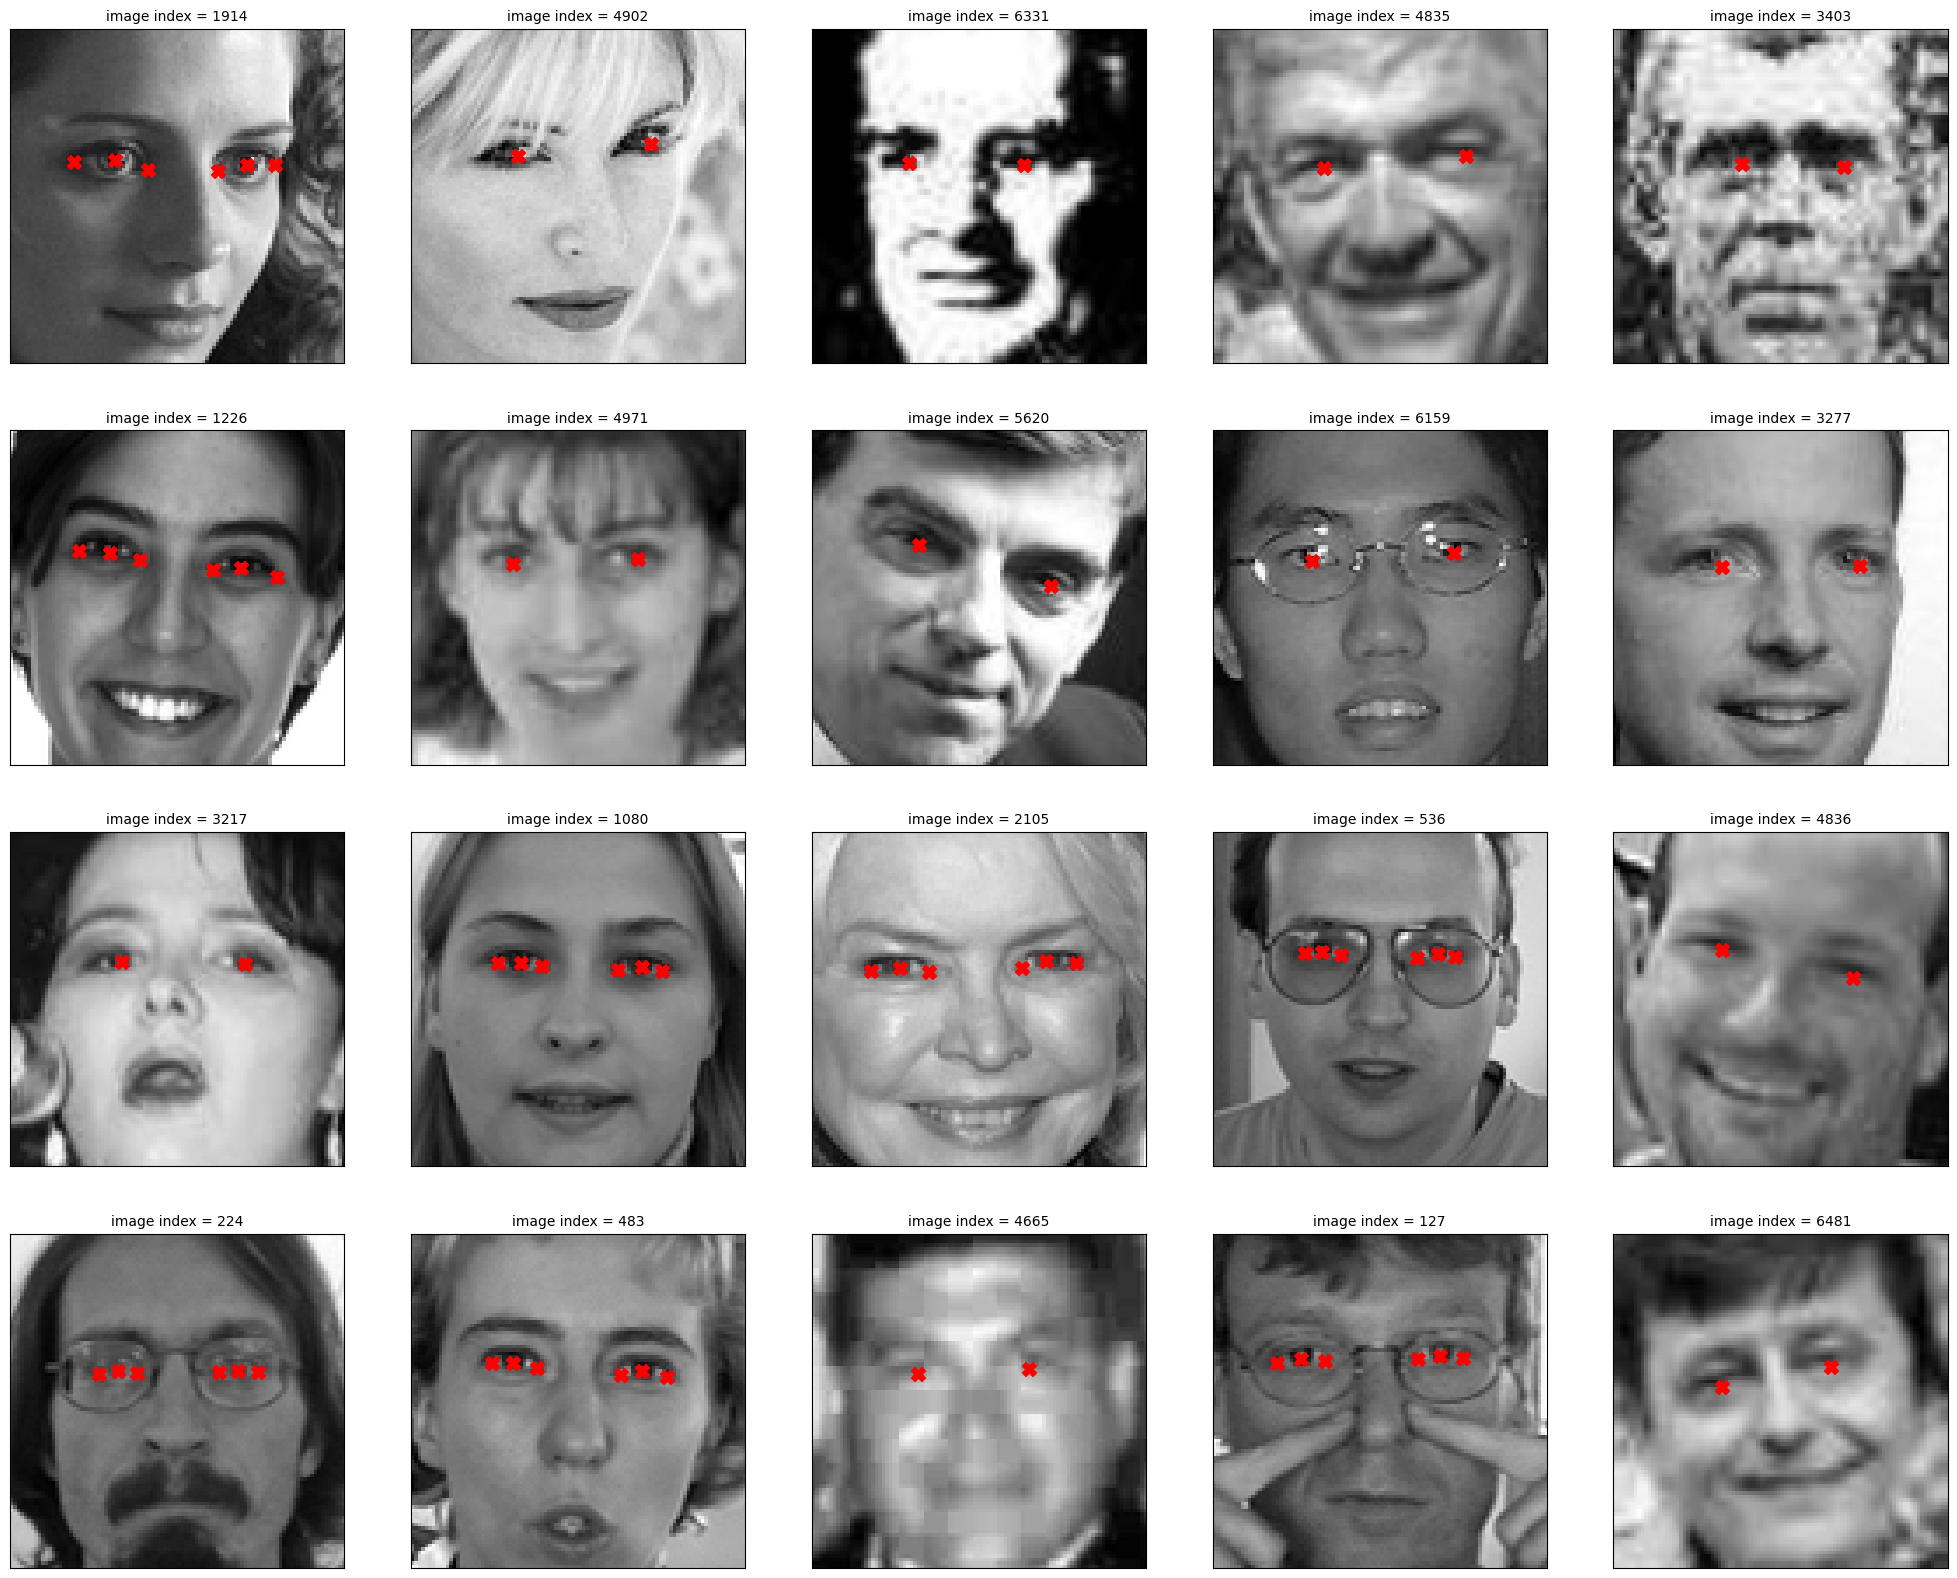

In [6]:
def plot_sample(X, Y, n_rows, n_cols, size=3):
    # sample n_rows*n_cols images
    i_rand = np.random.choice(Y.shape[0],n_rows*n_cols)
    n = 0
    fig, ax = plt.subplots(n_rows,n_cols,sharex=True,sharey=True,figsize=[n_cols*size,n_rows*size])
    for row in range(n_rows):
        for col in range(n_cols):
            ax[row,col].imshow(X[i_rand[n],:,:,0], cmap='gray')
            ax[row,col].scatter(Y[i_rand[n],0::2],Y[i_rand[n],1::2],marker='X',c='r',s=100)
            ax[row,col].set_xticks(())
            ax[row,col].set_yticks(())
            ax[row,col].set_title('image index = %d' % i_rand[n], fontsize=10)
            n += 1

plot_sample(X, Y, 4, 5, 5)

As we can see there are a lot of missing values in the dataset. Let's try to fill them using some methods. 

In [7]:
# Normalize the dataset
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

# Fit the KNN imputer model on the normalized data
imputer = KNNImputer(n_neighbors=11)
Y_imputed = imputer.fit_transform(Y_scaled)

# Combine the imputed and non-missing parts of the dataset
Y = scaler.inverse_transform(Y_imputed)

Let's see how the data looks like after imputation.

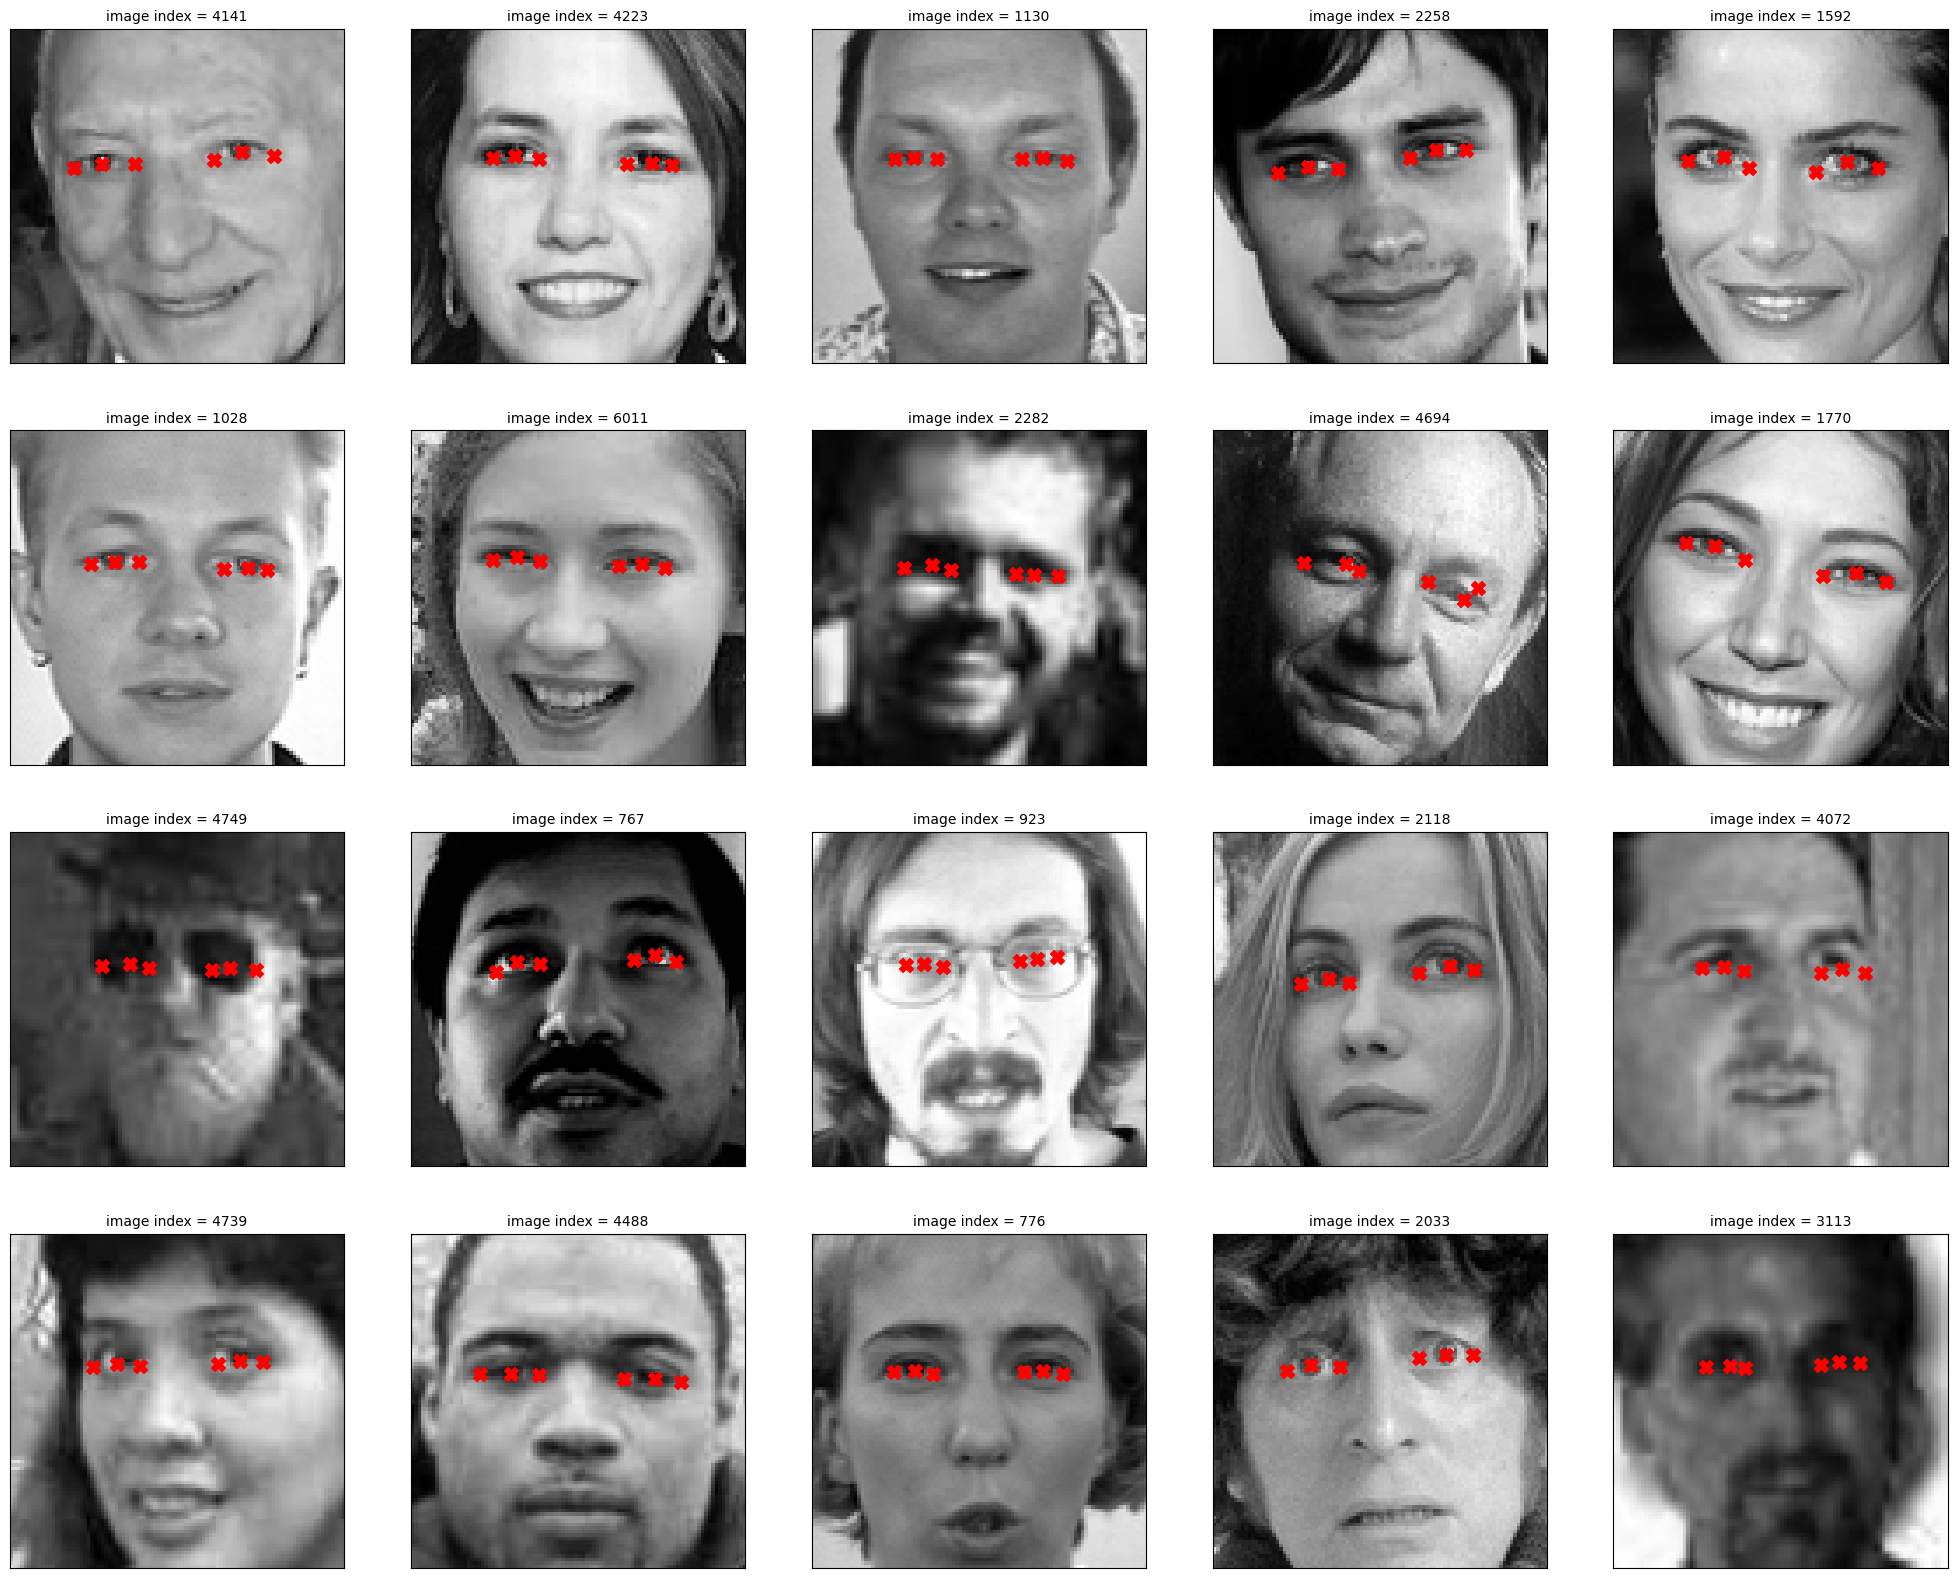

In [8]:
plot_sample(X, Y, 4, 5, 5)

## Data augmentation

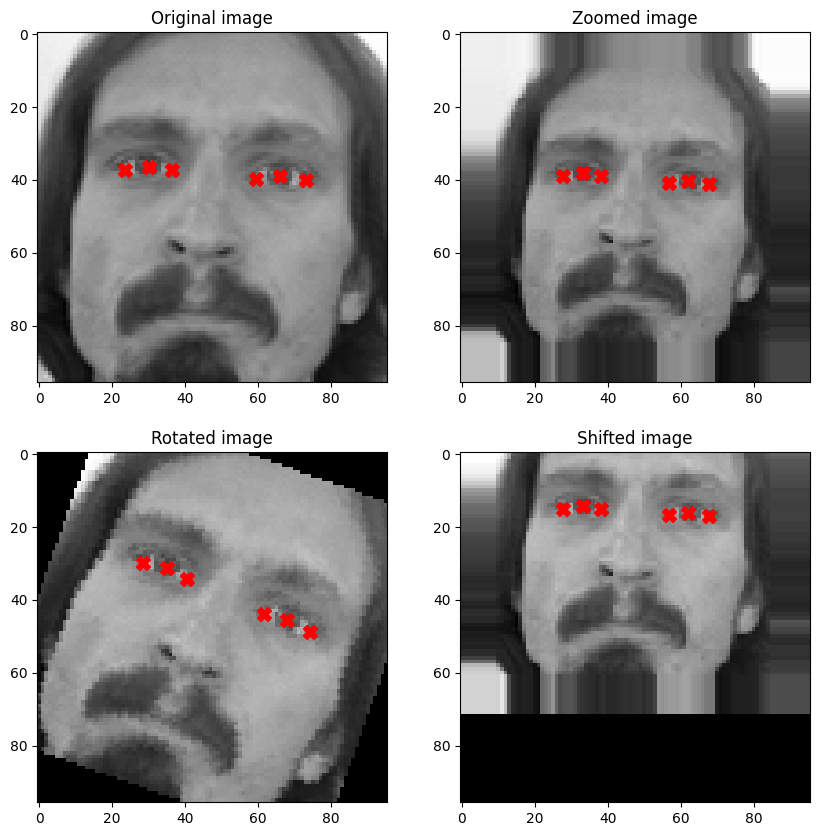

In [9]:
import cv2

# random zoom, fill mode is border replicate 
def random_zoom_out(image, landmarks, zoom_range=(0.5, 1.0)):
    zoom = np.random.uniform(zoom_range[0], zoom_range[1])
    new_size = (int(image.shape[1] * zoom), int(image.shape[0] * zoom))
    diff = np.abs(new_size[0] - image.shape[1]) // 2
        
    image_zoomed = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)

    diff_2 = diff_3 = diff if np.abs(new_size[0] - image.shape[1]) % 2 == 0 else diff + 1

    image_zoomed = cv2.copyMakeBorder(image_zoomed, diff, diff_2, diff, diff_3, cv2.BORDER_REPLICATE)
    landmarks_zoomed = landmarks * new_size[0] / image.shape[1] + diff
    
    if image_zoomed.shape[0] != 96 or image_zoomed.shape[1] != 96:
        print('image_zoomed shape:', image_zoomed.shape)
    
    return image_zoomed, landmarks_zoomed

# random rotation
def random_rotation(image, landmarks, angle_range=(-10, 10)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    center = (image.shape[1] // 2, image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    image_rotated = cv2.warpAffine(image, rot_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
    
    landmarks_rotated = np.copy(landmarks)
    for i in range(0, len(landmarks), 2):
        x = landmarks[i]
        y = landmarks[i + 1]
        landmarks_rotated[i] = rot_mat[0, 0] * x + rot_mat[0, 1] * y + rot_mat[0, 2]
        landmarks_rotated[i + 1] = rot_mat[1, 0] * x + rot_mat[1, 1] * y + rot_mat[1, 2]
    
    return image_rotated, landmarks_rotated

# random shift, choose a random shift value and a random direction
def random_shift(image, landmarks, shift_range=(0, 20)):
    shift = int(np.random.uniform(shift_range[0], shift_range[1]))
    direction = np.random.choice(['left', 'right', 'up', 'down'])
    
    if direction == 'left':
        shift_x = -shift
        shift_y = 0
    elif direction == 'right':
        shift_x = shift
        shift_y = 0
    elif direction == 'up':
        shift_x = 0
        shift_y = -shift
    else:
        shift_x = 0
        shift_y = shift
    
    shift_mat = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    image_shifted = cv2.warpAffine(image, shift_mat, (image.shape[1], image.shape[0]), flags=cv2.INTER_NEAREST)
    
    landmarks_shifted = np.copy(landmarks)
    for i in range(0, len(landmarks), 2):
        landmarks_shifted[i] += shift_x
        landmarks_shifted[i + 1] += shift_y
    
    return image_shifted, landmarks_shifted

# examples
image = X[0]
landmarks = Y[0]
image_zoomed, landmarks_zoomed = random_zoom_out(image, landmarks, zoom_range=(0.7, 0.9))
image_rotated, landmarks_rotated = random_rotation(image, landmarks, angle_range=(-30, 30))
image_shifted, landmarks_shifted = random_shift(image_zoomed, landmarks_zoomed, shift_range=(0, 30))

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(image[:,:,0], cmap='gray')
ax[0][0].scatter(landmarks[0::2], landmarks[1::2], marker='X', c='r', s=100)
ax[0][0].set_title('Original image')

ax[0][1].imshow(image_zoomed, cmap='gray')
ax[0][1].scatter(landmarks_zoomed[0::2], landmarks_zoomed[1::2], marker='X', c='r', s=100)
ax[0][1].set_title('Zoomed image')

ax[1][0].imshow(image_rotated, cmap='gray')
ax[1][0].scatter(landmarks_rotated[0::2], landmarks_rotated[1::2], marker='X', c='r', s=100)
ax[1][0].set_title('Rotated image')

ax[1][1].imshow(image_shifted, cmap='gray')
ax[1][1].scatter(landmarks_shifted[0::2], landmarks_shifted[1::2], marker='X', c='r', s=100)
ax[1][1].set_title('Shifted image')

plt.show()

apply random zoom and rotation to the dataset

In [10]:
from joblib import Parallel, delayed

# Define a function that performs data augmentation on a single image
def augment_image(image, landmarks):
    image_zoomed, landmarks_zoomed = random_zoom_out(image, landmarks, zoom_range=(0.7, 0.9))
    image_rotated, landmarks_rotated = random_rotation(image, landmarks, angle_range=(-30, 30))
    image_shifted, landmarks_shifted = random_shift(image_zoomed, landmarks_zoomed, shift_range=(-30, 30))

    image_zoomed = np.expand_dims(image_zoomed, axis=2)
    image_rotated = np.expand_dims(image_rotated, axis=2)
    image_shifted = np.expand_dims(image_shifted, axis=2)

    return [image_zoomed, image_rotated, image_shifted], [landmarks_zoomed, landmarks_rotated, landmarks_shifted]

# Use joblib to parallelize the data augmentation
results = Parallel(n_jobs=-1)(delayed(augment_image)(X[i], Y[i]) for i in range(X.shape[0]))

# Extract the results
X_augmented = np.array([result[0] for result in results])
Y_augmented = np.array([result[1] for result in results])

# Flatten the results
X_augmented = np.concatenate(X_augmented, axis=0)
Y_augmented = np.concatenate(Y_augmented, axis=0)

Show the augmented dataset

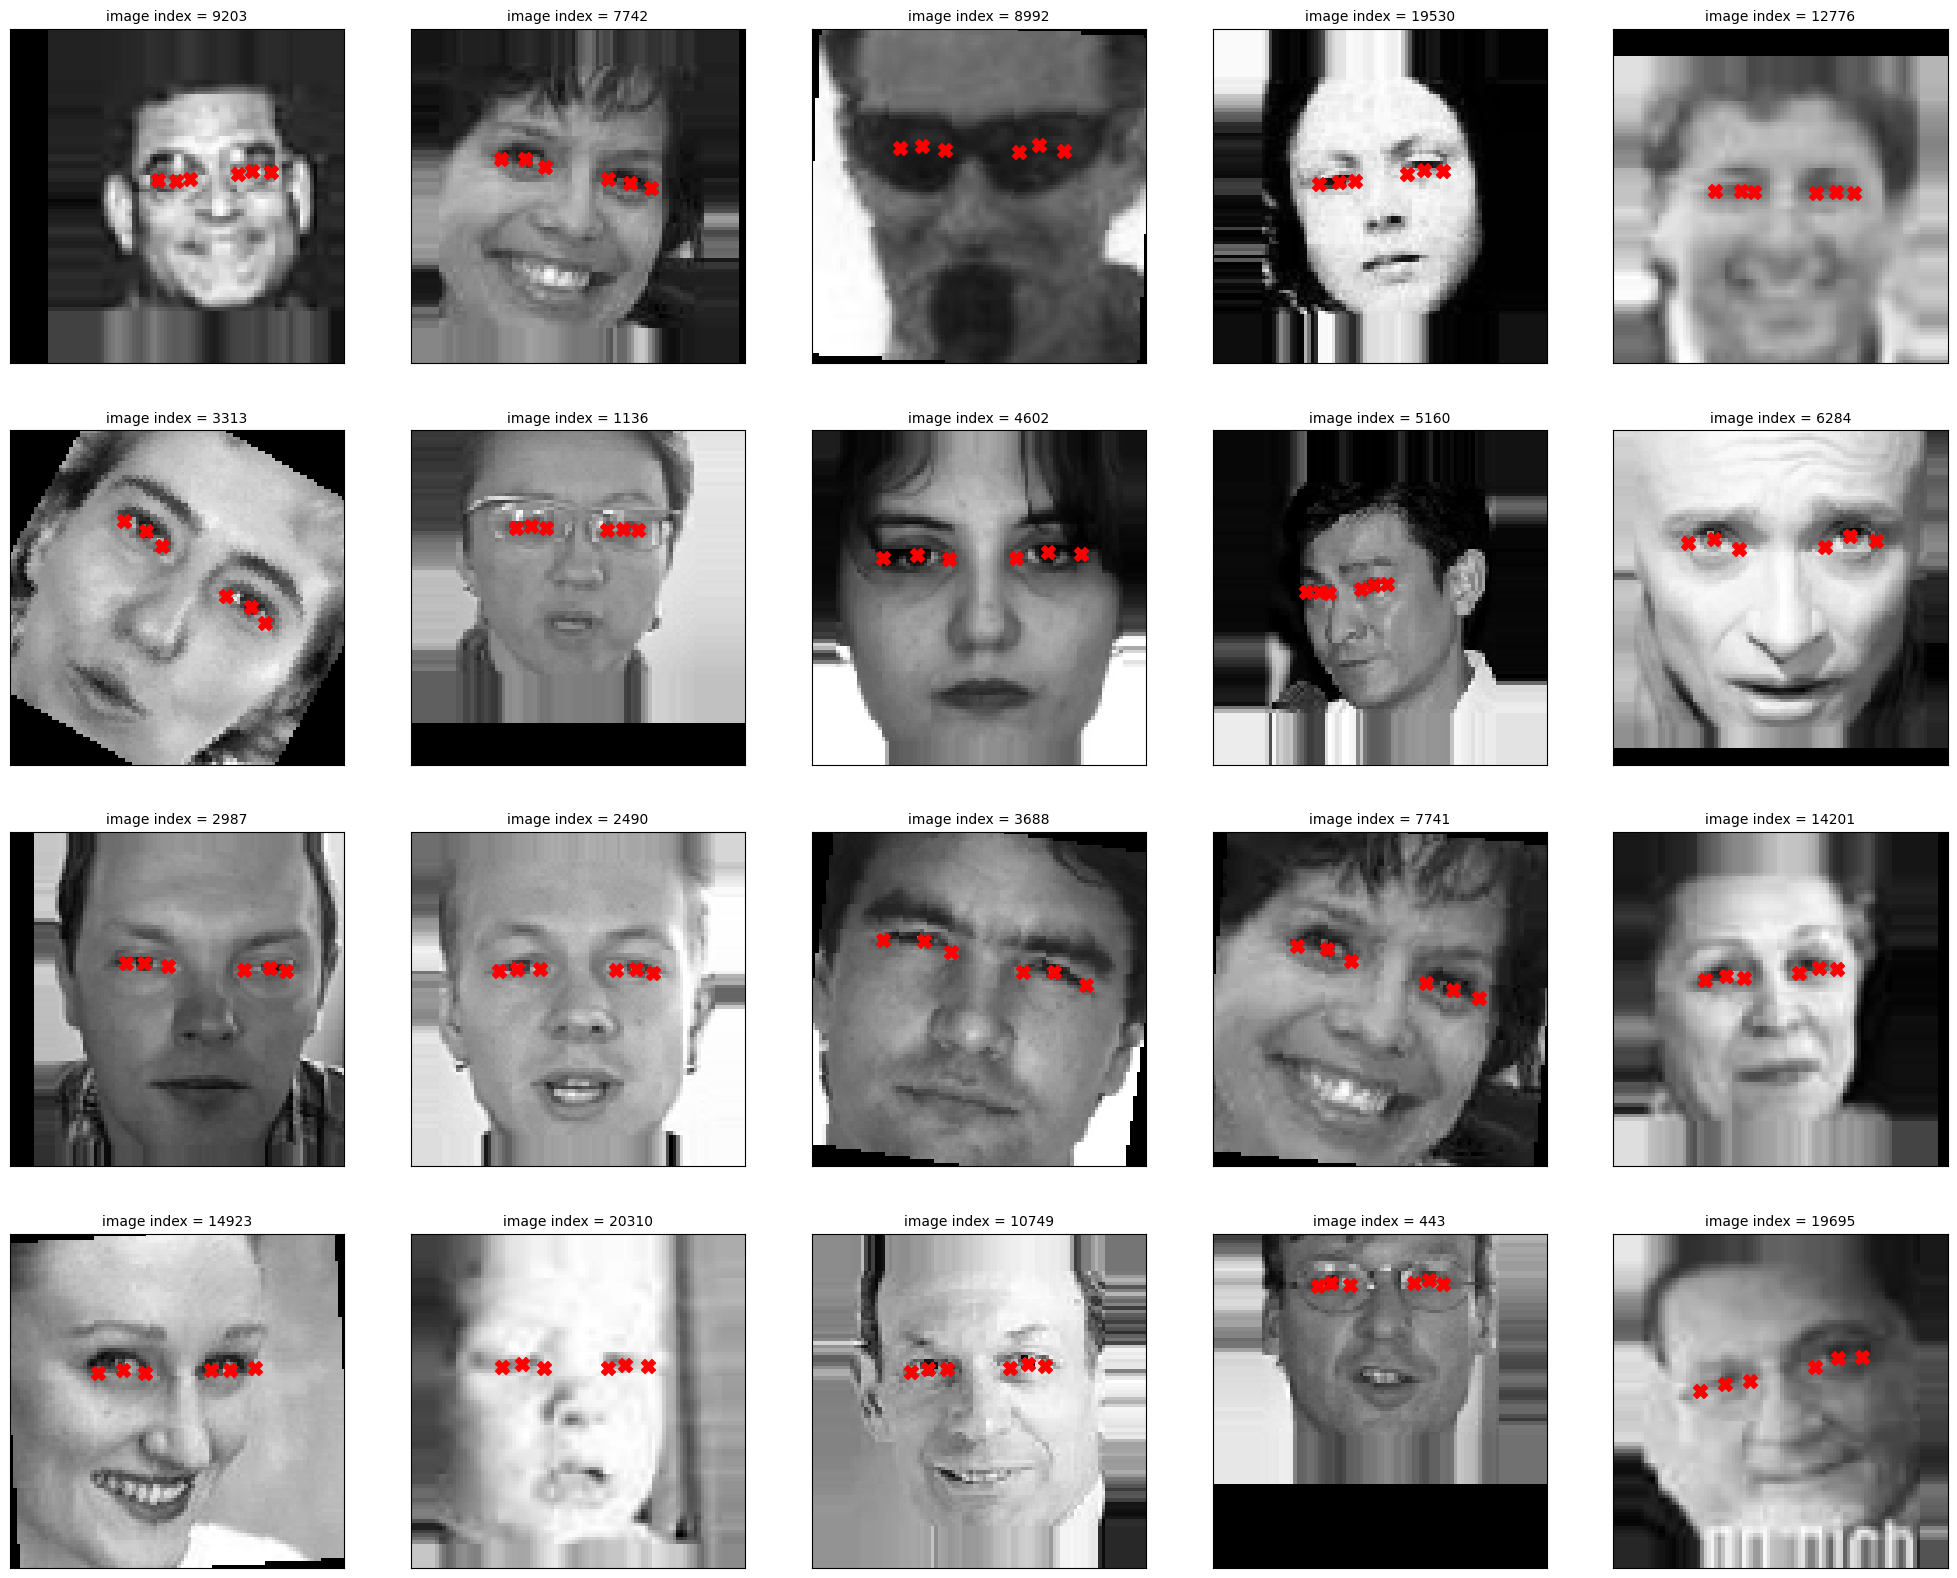

In [11]:
plot_sample(X_augmented, Y_augmented, 4, 5, 5)

## Train, test and validation split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_augmented, Y_augmented, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)

X_train shape: (13503, 96, 96, 1)
Y_train shape: (13503, 12)
X_test shape: (4220, 96, 96, 1)
Y_test shape: (4220, 12)
X_val shape: (3376, 96, 96, 1)
Y_val shape: (3376, 12)


## Model

In [33]:
model = Sequential([
    Input(shape=(96, 96, 1)),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', kernel_initializer=glorot_uniform(), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    BatchNormalization(),
    Conv2D(256, (3, 3), padding='same', kernel_initializer=glorot_uniform(), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    BatchNormalization(),
    Conv2D(512, (3, 3), padding='same', kernel_initializer=glorot_uniform(), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(1028, kernel_initializer=glorot_uniform(), activation='relu'),
    Dropout(0.5),
    Dense(64, kernel_initializer=glorot_uniform(), activation='relu'),
    Dense(12, kernel_initializer=glorot_uniform(), activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 96, 96, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1028)           │    75,793,412 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        65,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,338,196 (295.02 MB)

 Trainable params: 77,337,426 (295.02 MB)

 Non-trainable params: 770 (3.01 KB)

Compile the model

In [34]:
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy', 'mae'])

# early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15, 
    verbose=1, 
    restore_best_weights=True
)

Train the model

In [35]:
history = model.fit(
    X_train, Y_train,
    batch_size=48,
    epochs=80,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping]
)

Epoch 1/90
282/282 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.4033 - loss: 1243.0898 - r2_score: -18.3407 - val_accuracy: 0.9790 - val_loss: 85.1018 - val_r2_score: -0.4208
Epoch 2/90
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.8324 - loss: 67.0704 - r2_score: -0.0998 - val_accuracy: 0.9772 - val_loss: 185.5050 - val_r2_score: -2.1511
Epoch 3/90
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.8901 - loss: 56.8272 - r2_score: 0.0684 - val_accuracy: 0.9698 - val_loss: 103.0572 - val_r2_score: -0.7403
Epoch 4/90
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9205 - loss: 53.2708 - r2_score: 0.1541 - val_accuracy: 0.9600 - val_loss: 55.5509 - val_r2_score: 0.0664
Epoch 5/90
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9272 - loss: 50.7387 - r2_score: 0.1800 - val_accuracy: 0.9778 - val_loss: 56.7258 - val_r2_score: 0.0452
Epoch 6/90
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - accuracy: 0.9409 - loss: 44.5821 - r2_score: 0.2816 - val_accura

Plot the loss

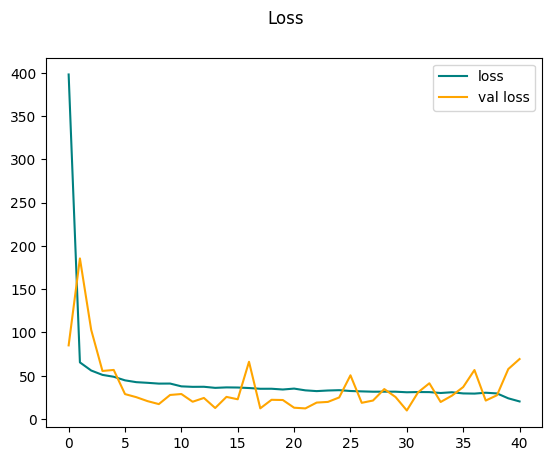

In [36]:
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

Save the model

In [37]:
model.save('./models/facial_landmark_detection.h5')

## Test the model
load the model

In [13]:
model = tf.keras.models.load_model('./models/facial_landmark_detection.h5')
model.evaluate(X_test, Y_test)

I0000 00:00:1715873770.011830   18650 service.cc:145] XLA service 0x7167b00094b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715873770.011852   18650 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-16 17:36:10.039684: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-16 17:36:10.120649: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715873770.728390   18796 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_178', 36 bytes spill stores, 36 bytes spill loads

I0000 00:00:1715873770.802440   18791 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_178', 136 bytes spill stores, 136 bytes spill loads


 17/132 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9663 - loss: 9.4325 - r2_score: 0.8669

I0000 00:00:1715873772.270296   18650 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


127/132 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9777 - loss: 9.3417 - r2_score: 0.8534

I0000 00:00:1715873774.043901   18834 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_178', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1715873774.280209   18846 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_178', 196 bytes spill stores, 196 bytes spill loads



132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9778 - loss: 9.3423 - r2_score: 0.8532


[9.376251220703125, 0.9803317785263062, 0.8493514060974121]

Let's see how the model performs on the test set.

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


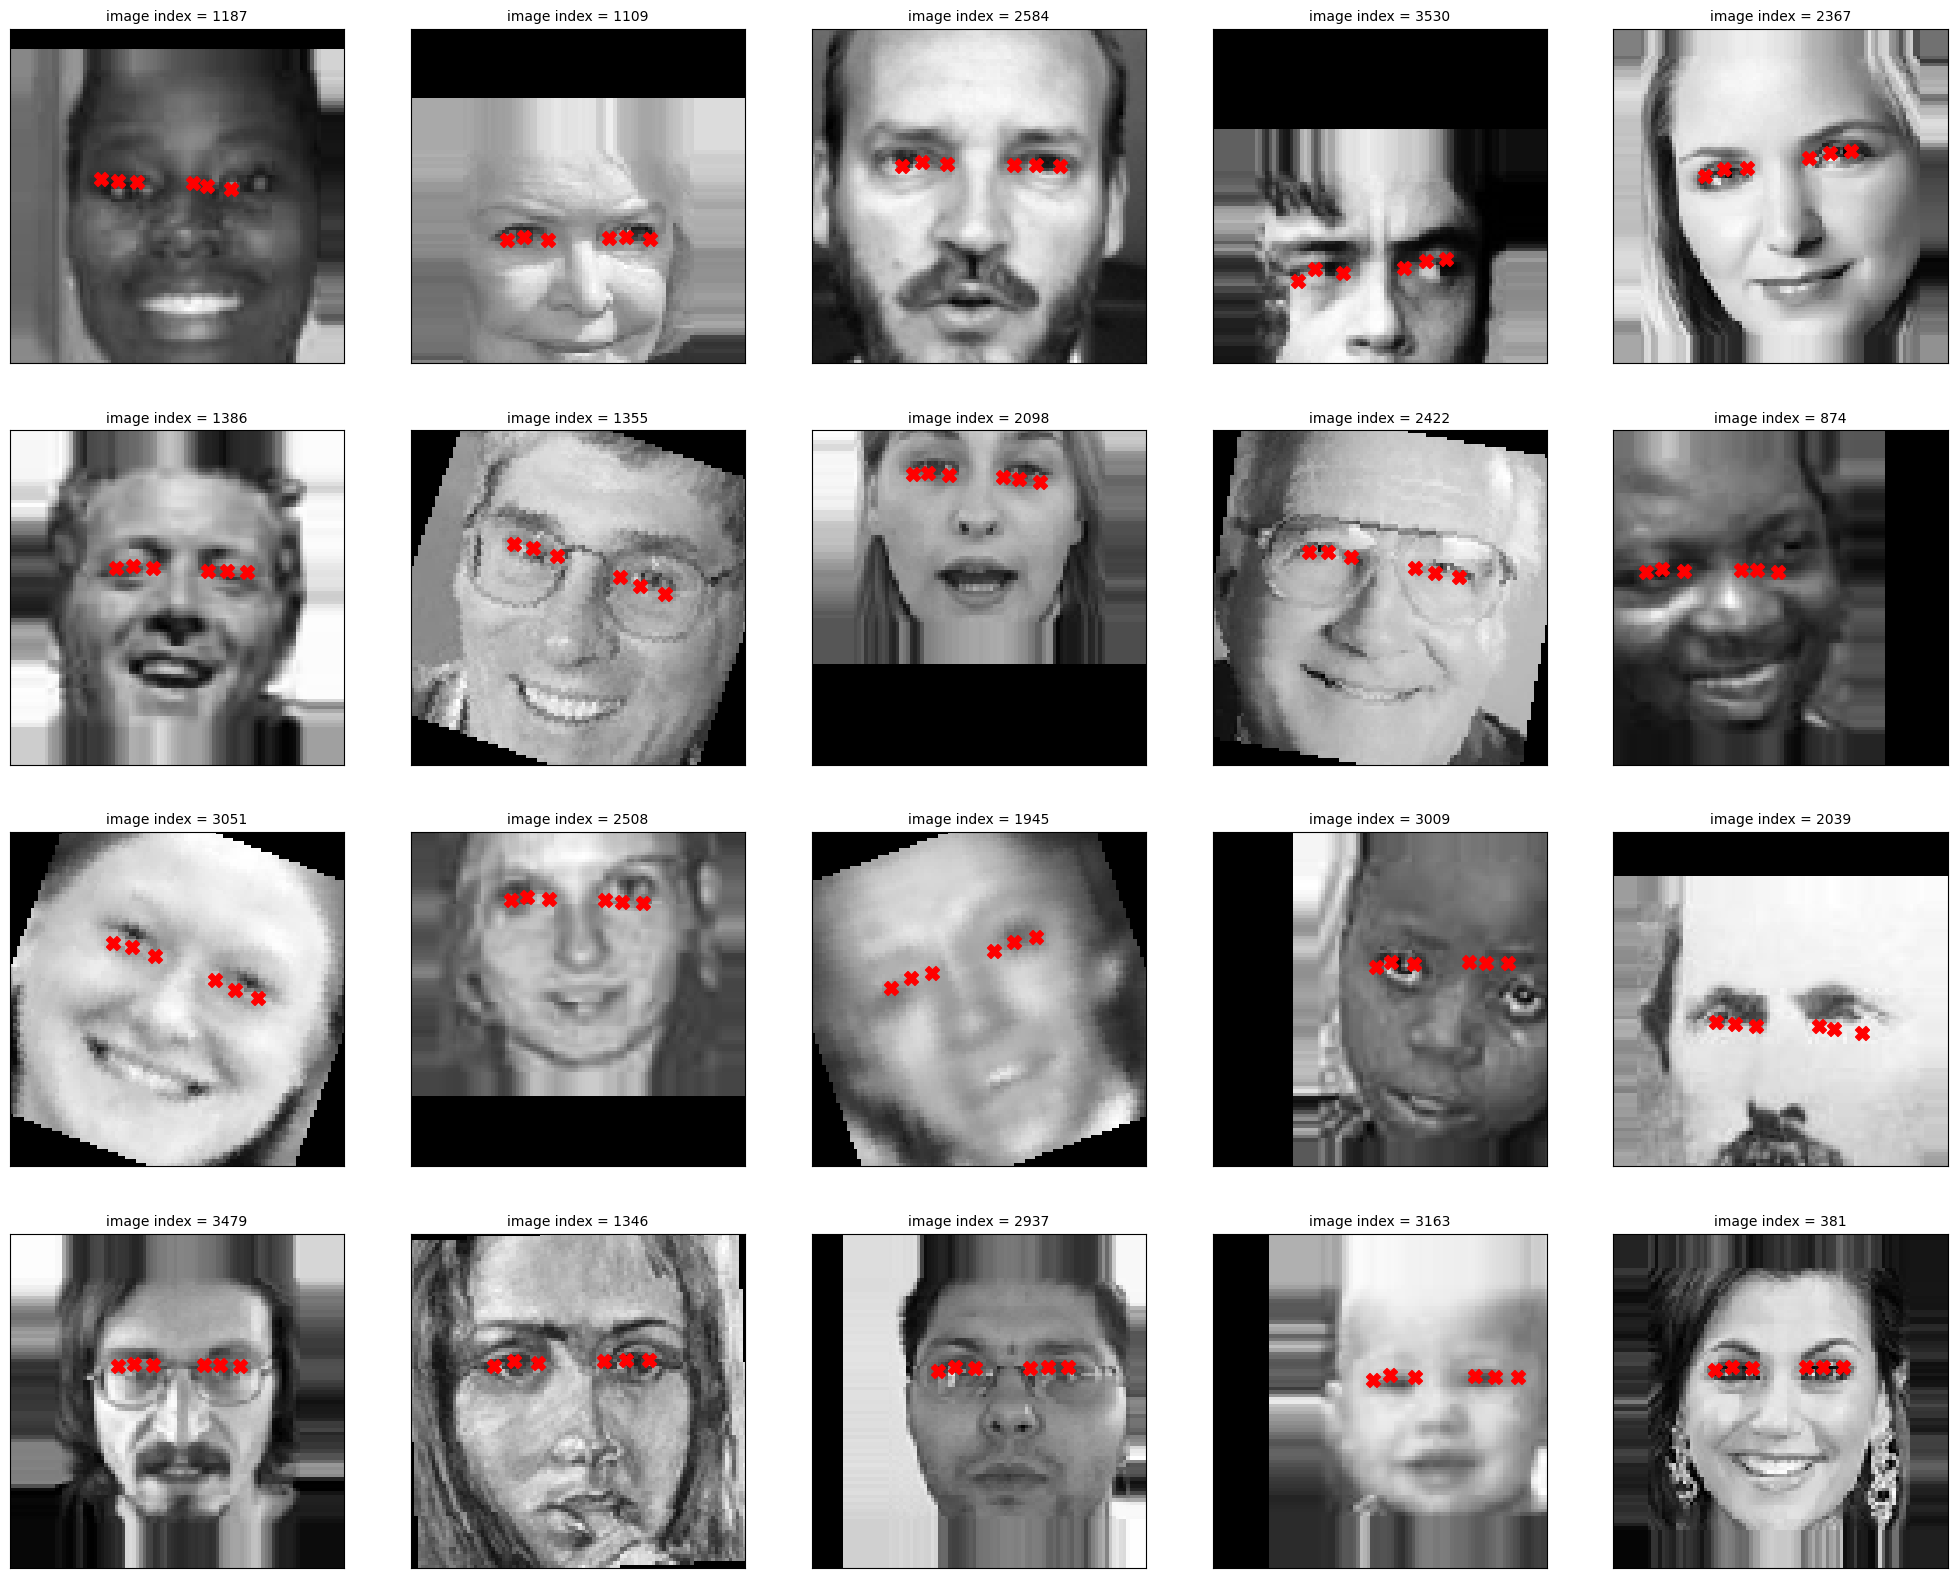

In [39]:
Y_pred = model.predict(X_test)

plot_sample(X_test, Y_pred, 4, 5, 5)

Test the model on CASIA-Iris-Distance dataset

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[62.52185  42.355522 31.172125 40.177048 57.08652  41.62727  70.10904
  43.370533 37.92848  40.846462 25.50481  40.06351 ]]


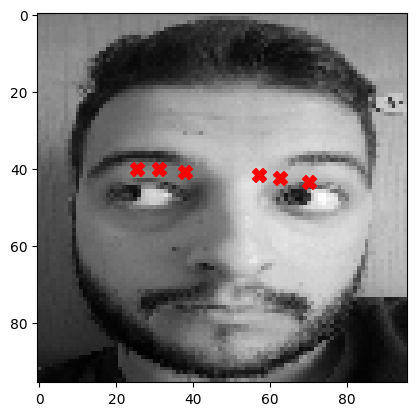

In [22]:
test_image = cv2.imread('./dataset/test_personal.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[[60.651764 41.949802 34.04429  39.50445  55.833244 41.406384 66.845825
  42.683464 39.81135  40.255405 29.15677  39.53181 ]]


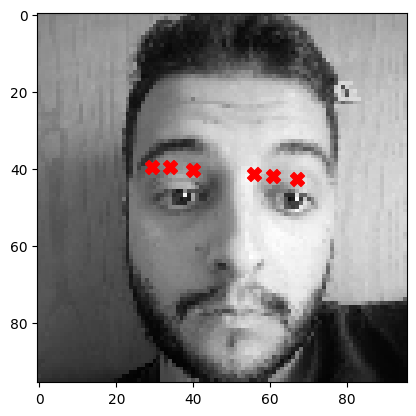

In [21]:
test_image = cv2.imread('./dataset/test_personal_2.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[61.197693 35.71979  31.064339 35.41814  55.308968 35.892876 67.530685
  35.917843 37.697704 35.871304 25.724913 36.55595 ]]


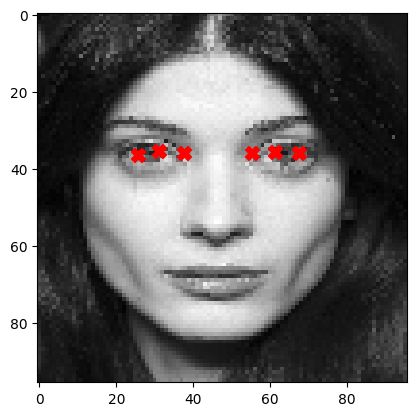

In [16]:
test_image = cv2.imread('./dataset/test_face.jpg', cv2.IMREAD_GRAYSCALE)
test_image = cv2.resize(test_image, (96, 96))
test_image = np.expand_dims(test_image, axis=2)

test_landmarks = model.predict(test_image.reshape(1, 96, 96, 1) / 255.0)

print(test_landmarks)

plt.imshow(test_image[:,:,0], cmap='gray')
plt.scatter(test_landmarks[0,0::2],test_landmarks[0,1::2],marker='X',c='r',s=100)
plt.show()